In [150]:
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import filters
import numpy as np
from PIL import Image

In [149]:
def show_img(img, width=10):
    plt.figure(figsize=(width, width / 1000 * 727))
    plt.imshow(img, cmap='gray')   
    plt.axis('off')   
    plt.show()  


# Find Piece Contours

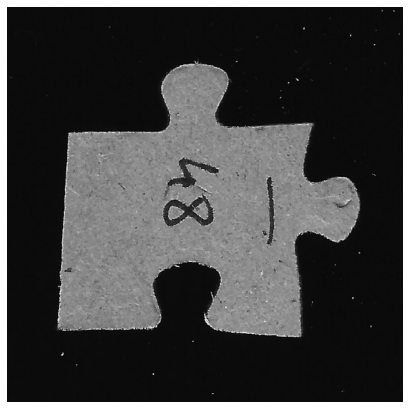

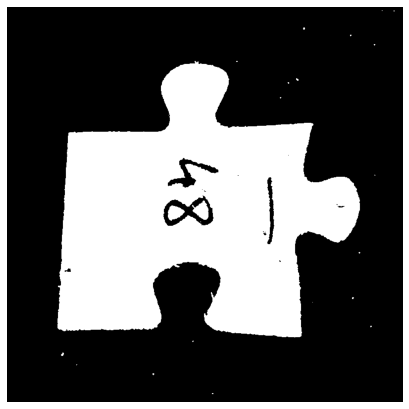

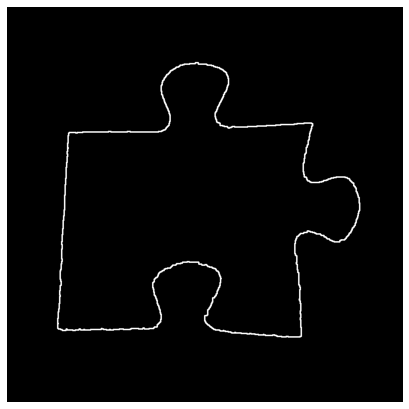

In [151]:
import cv2
import numpy as np

image = cv2.imread("../data/single.jpg", cv2.IMREAD_GRAYSCALE)

blurred = cv2.GaussianBlur(image, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# apply morphological opening to remove small noise
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(binary)
min_area = 500
for cnt in contours:
    if cv2.contourArea(cnt) > min_area:
        cv2.drawContours(mask, [cnt], -1, (255,255,255), 2)

show_img(image)
show_img(binary)
show_img(mask)

From this point we compute the convex hull of the contours and the convexity defects of that hull, meaning any point on the contour that deviate from the hull. Using a threshold for how much deviation from the hull, we can find the points that make up the notches (interjambs) and blanks of the puzzle piece.

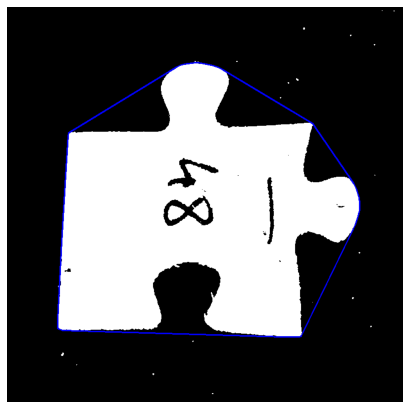

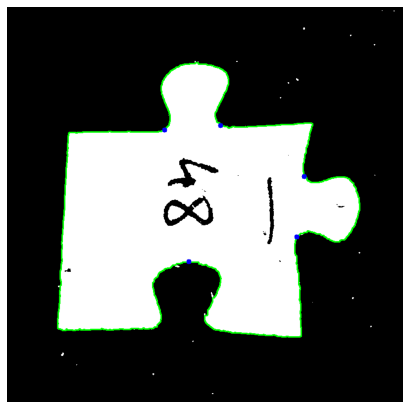

In [152]:
# assume the largest contour is the puzzle piece
contour = max(contours, key=cv2.contourArea)

# approximate the contour to get main shape
epsilon = 0.02 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

# Find convex hull and defects (concave points)
hull = cv2.convexHull(contour, returnPoints=False)
defects = cv2.convexityDefects(contour, hull)


output = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

hull_output = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

hull_points = np.array([contour[i][0] for i in hull.flatten()])

cv2.drawContours(hull_output, [hull_points], -1, (255, 0, 0), 2)

show_img(cv2.cvtColor(hull_output, cv2.COLOR_BGR2RGB))

for i in range(len(contour)):
    p1 = tuple(contour[i][0])
    p2 = tuple(contour[(i + 1) % len(contour)][0])

    cv2.line(output, p1, p2, (0, 255, 0), 2)

notch_defects = []


if defects is not None:
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(contour[s][0])
        end = tuple(contour[e][0])
        far = tuple(contour[f][0])

        # If defect depth is significant, it's a notch
        # d = threshold to filter out noise
        if (d > 10000):  
            notch_defects.append(far)
            cv2.circle(output, far, 5, (0, 0, 255), -1)

# Show results
show_img(output)

In the first image we see the puzzle piece with the blue convex hall surrounding it.
In the second one we see the defection points as well as the contours around the piece.

In [153]:
defects

array([[[    0,     5,     2,   473]],

       [[    5,     9,     8,   248]],

       [[    9,    13,    10,   343]],

       [[   13,   103,    78, 24555]],

       [[  103,   105,   104,   210]],

       [[  105,   107,   106,   238]],

       [[  107,   121,   110,   412]],

       [[  121,   139,   128,   537]],

       [[  139,   173,   158,   892]],

       [[  173,   177,   175,   256]],

       [[  178,   182,   181,   300]],

       [[  182,   442,   306, 37484]],

       [[  442,   447,   444,   256]],

       [[  447,   449,   448,   114]],

       [[  450,   563,   497, 24474]],

       [[  563,   573,   568,   324]],

       [[  573,   581,   578,   297]],

       [[  582,   584,   583,   232]],

       [[  584,   592,   591,   463]],

       [[  592,   596,   595,   458]],

       [[  596,   671,   636, 19083]],

       [[  671,   775,   705, 25344]],

       [[  775,   781,   780,   191]],

       [[  781,   787,   784,   324]],

       [[  787,   789,   788,   186]],



In [154]:
notch_defects

[(318, 250), (367, 516), (585, 466), (600, 344), (431, 241)]

In [155]:
img_shape = image.shape
width = img_shape[0]
height = img_shape[1]

left_top_point = approx[0]
left_top_point_idx = 0
min_corner_dist = width + height

for idx, point in enumerate(approx):
    p_corner_dist = point[0][0] + point[0][1]
    
    if p_corner_dist < min_corner_dist:
        min_corner_dist = p_corner_dist
        left_top_point = point
        left_top_point_idx = idx

print(min_corner_dist)
print(left_top_point)
print(left_top_point_idx)


380
[[124 256]]
7


In [156]:
notch_defects
print((317, 250) in notch_defects)

False


In [82]:
test_p = left_top_point.flatten()
print(tuple(test_p))

(124, 256)


In [157]:
def get_max_piece_size(contour):
    points = contour.reshape(-1, 2)

    top_idx = np.argmin(points[:, 1])
    bottom_idx = np.argmax(points[:, 1])
    left_idx = np.argmin(points[:, 0])
    right_idx = np.argmax(points[:, 0])

    height = abs(points[bottom_idx][1] - points[top_idx][1])
    width = abs(points[right_idx][0] - points[left_idx][0])

    return max(height, width)

In [158]:
def nearest_border(point, img_shape, border=None):
    width, height = img_shape
    x, y = point

    # Compute distances to borders
    distances = {
        "left": (x, 0),
        "bottom": (height - y, 1),
        "right": (width - x, 2),
        "top": (y, 3),
    }

    # Find the nearest border
    nearest = min(distances.items(), key=lambda item: item[1][0])
    
    if border is not None:
        return border, distances[border][0]

    return nearest[0], nearest[1][0]

In [159]:
edges = ["left", "bottom", "right", "top"]
edge_idx = 0

# simple_contours = np.concatenate((approx[left_top_point_idx + 1:], approx[:left_top_point_idx]))
last_point = left_top_point.flatten()
current_idx = left_top_point_idx

piece_size = get_max_piece_size(contour)

for i in range(len(approx)):
    if current_idx >= len(approx):
        break
    point = approx[current_idx].flatten()
    last_point = approx[current_idx - 1].flatten()
    dist = np.linalg.norm(last_point - point)
    print(point)
    if tuple(point) not in notch_defects:
        if dist > (piece_size/2):
            print(f"{edges[edge_idx]} edge is straight")
            edge_idx += 1
            
        current_idx += 1
    else:
        print("defect")
        border, dist = nearest_border(last_point, img_shape)
        _, defect_dist = nearest_border(point, img_shape, border)
        print(border)
        print(dist)
        print(defect_dist)
        if defect_dist > dist:
            print(f"{edges[edge_idx]} edge has a blank")
            edge_idx += 1
            current_idx += 3
        else:
            _, next_dist = nearest_border(approx[current_idx + 1], img_shape, border)
            if defect_dist > (next_dist + dist) / 2:
                print(f"{edges[edge_idx]} edge has an interjamb")
                edge_idx += 1
                current_idx += 5
            else:
                current_idx += 1
        
    
   
    

[124 256]
[102 650]
left edge is straight
[303 648]
[367 516]
defect
bottom
152
284
bottom edge has a blank
[583 471]
[681 472]


This is a first attempt at classifying each side of the puzzle piece. However, it doesn't seem to work fully now and I can see a lot of improvements to do from here. Maybe even just rewriting the defect detection algorithm on my own to calculate the side-classifications directly in that process.